<a href="https://colab.research.google.com/github/VrindaBajaj20/ai-attack-snow3g-nea1/blob/main/experiments/nea1_bitwiseprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.models import Model

In [7]:
print("Please upload the CSV file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

required_columns = ["COUNT", "Direction", "Bearer ID", "LENGTH", "KEY"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

Please upload the CSV file.


Saving snow3g_keystream (1).csv to snow3g_keystream (1).csv


In [9]:
# Validate required columns
required_columns = ["KEY", "Direction", "LENGTH", "COUNT", "Bearer ID", "Keystream"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

In [10]:
# -------------------------------
# Step 2: Convert NEA1 binary to hex
# -------------------------------
def bin_to_hex(bin_str):
    # Remove any spaces or line breaks
    bin_str = str(bin_str).replace(" ", "").replace("\n", "")
    return hex(int(bin_str, 2))[2:].zfill(len(bin_str)//4)

df['Keystream_hex'] = df['Keystream'].apply(bin_to_hex)

In [11]:
# -------------------------------
# Step 3: Convert hex to bits (same as NEA3)
# -------------------------------
def hex_to_bits(hex_str):
    return np.array([int(b) for b in bin(int(hex_str, 16))[2:].zfill(128)])

df['Keystream_bits'] = df['Keystream_hex'].apply(hex_to_bits)
df['Key_bits'] = df['KEY'].apply(hex_to_bits)

In [12]:

# -------------------------------
# Step 4: Prepare ML arrays
# -------------------------------
X = np.stack(df['Keystream_bits'].values).astype(np.float32)
y = np.stack(df['Key_bits'].values).astype(np.int32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("NEA1 preprocessing complete! X and y are ready for your ML pipeline.")


NEA1 preprocessing complete! X and y are ready for your ML pipeline.


In [13]:
## Random Forest
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

bitwise_acc_rf = np.mean(y_pred_rf == y_test, axis=0)
print(f"Random Forest Bitwise Accuracy: {np.mean(bitwise_acc_rf) * 100:.2f}%")

## XGBoost
from xgboost import XGBClassifier

xgb_models = [XGBClassifier(eval_metric='logloss') for _ in range(128)]
for i in range(128):
    xgb_models[i].fit(X_train, y_train[:, i])

y_pred_xgb = np.column_stack([model.predict(X_test) for model in xgb_models])
bitwise_acc_xgb = np.mean(y_pred_xgb == y_test, axis=0)
print(f"XGBoost Bitwise Accuracy: {np.mean(bitwise_acc_xgb)*100:.2f}%")

## MLP
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(128,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='sigmoid')  # 128-bit output
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=0)

y_pred_mlp = (mlp.predict(X_test) > 0.5).astype(int)
bitwise_acc_mlp = np.mean(y_pred_mlp == y_test, axis=0)
print(f"MLP Bitwise Accuracy: {np.mean(bitwise_acc_mlp) * 100:.2f}%")

## CNN
X_train_cnn = X_train.reshape(-1, 128, 1)
X_test_cnn = X_test.reshape(-1, 128, 1)

cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128,1)),
    Conv1D(128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train, epochs=20, batch_size=128, validation_data=(X_test_cnn, y_test), verbose=0)

y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int)
bitwise_acc_cnn = np.mean(y_pred_cnn == y_test, axis=0)
print(f"CNN Bitwise Accuracy: {np.mean(bitwise_acc_cnn) * 100:.2f}%")

## Transformer
def create_transformer():
    inputs = Input(shape=(128, 1))
    x = tf.keras.layers.Dense(128)(inputs)
    pos_enc = tf.reshape(tf.constant(np.random.rand(1,128,128), dtype=tf.float32), (1,128,128))
    x = Add()([x, pos_enc])
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=x)

X_train_tf = X_train.reshape(-1, 128, 1)
X_test_tf = X_test.reshape(-1, 128, 1)

transformer = create_transformer()
transformer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
transformer.fit(X_train_tf, y_train, epochs=20, batch_size=128, validation_data=(X_test_tf, y_test), verbose=0)

y_pred_tf = (transformer.predict(X_test_tf) > 0.5).astype(int)
bitwise_acc_tf = np.mean(y_pred_tf == y_test, axis=0)
print(f"Transformer Bitwise Accuracy: {np.mean(bitwise_acc_tf) * 100:.2f}%")

## Ensemble(CNN+RF+XGBoost)
from scipy import stats


ensemble_predictions = np.stack([y_pred_rf, y_pred_xgb, y_pred_cnn])

y_pred_ensemble = stats.mode(ensemble_predictions, axis=0)[0][0]

bitwise_acc_ensemble = np.mean(y_pred_ensemble == y_test, axis=0)
print(f"Ensemble (RF+XGB+CNN) Bitwise Accuracy: {np.mean(bitwise_acc_ensemble) * 100:.2f}%")

Random Forest Bitwise Accuracy: 51.41%
XGBoost Bitwise Accuracy: 50.94%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
MLP Bitwise Accuracy: 49.49%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
CNN Bitwise Accuracy: 50.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Transformer Bitwise Accuracy: 49.10%
Ensemble (RF+XGB+CNN) Bitwise Accuracy: 50.78%


In [14]:
print("\n--- Bitwise Prediction Accuracy Summary ---")
print(f"Random Forest     : {np.mean(bitwise_acc_rf) * 100:.2f}%")
print(f"XGBoost           : {np.mean(bitwise_acc_xgb) * 100:.2f}%")
print(f"MLP               : {np.mean(bitwise_acc_mlp) * 100:.2f}%")
print(f"CNN               : {np.mean(bitwise_acc_cnn) * 100:.2f}%")
print(f"Transformer       : {np.mean(bitwise_acc_tf) * 100:.2f}%")


--- Bitwise Prediction Accuracy Summary ---
Random Forest     : 51.41%
XGBoost           : 50.94%
MLP               : 49.49%
CNN               : 50.59%
Transformer       : 49.10%


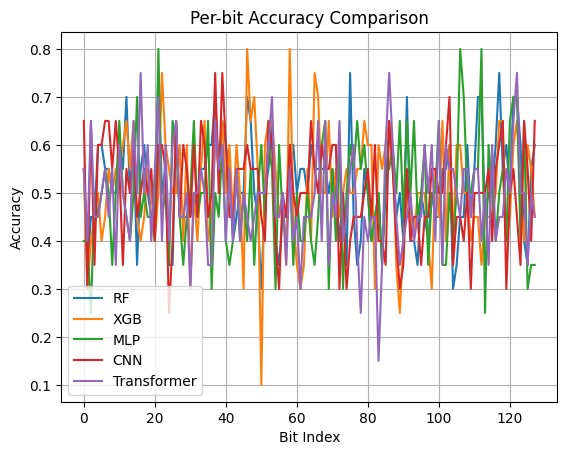

In [15]:
import matplotlib.pyplot as plt

plt.plot(bitwise_acc_rf, label="RF")
plt.plot(bitwise_acc_xgb, label="XGB")
plt.plot(bitwise_acc_mlp, label="MLP")
plt.plot(bitwise_acc_cnn, label="CNN")
plt.plot(bitwise_acc_tf, label="Transformer")
plt.title("Per-bit Accuracy Comparison")
plt.xlabel("Bit Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()